In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
admissions = pd.read_csv("admissions.csv")
fatalities = pd.read_csv("fatalities.csv")
metrics = pd.read_csv("metrics.csv")
prescriptions = pd.read_csv("prescriptions.csv")
smokers = pd.read_csv("smokers.csv")

In [4]:
for df, name in zip([admissions, fatalities, metrics, prescriptions, smokers], 
                    ['Admissions', 'Fatalities', 'Metrics', 'Prescriptions', 'Smokers']):
    print(f"\n{name}:\n", df.head())
    print(df.info())



Admissions:
       Year                                         ICD10 Code  \
0  2014/15                                          All codes   
1  2014/15  C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...   
2  2014/15                                            C00-D48   
3  2014/15                                            J00-J99   
4  2014/15                                            I00-I99   

                               ICD10 Diagnosis  \
0                               All admissions   
1  All diseases which can be caused by smoking   
2                                  All cancers   
3                     All respiratory diseases   
4                     All circulatory diseases   

                                Diagnosis Type                Metric  Sex  \
0                               All admissions  Number of admissions  NaN   
1  All diseases which can be caused by smoking  Number of admissions  NaN   
2                                  All cancers  Number of admis

In [5]:
# Fill missing prescription values
prescriptions['Varenicline (Champix) Prescriptions'] = prescriptions['Varenicline (Champix) Prescriptions'].fillna(
    prescriptions['All Pharmacotherapy Prescriptions'] 
    - prescriptions['Nicotine Replacement Therapy (NRT) Prescriptions'] 
    - prescriptions['Bupropion (Zyban) Prescriptions']
)

# Fill missing cost values
prescriptions['Net Ingredient Cost of Varenicline (Champix)'] = prescriptions['Net Ingredient Cost of Varenicline (Champix)'].fillna(
    prescriptions['Net Ingredient Cost of All Pharmacotherapies'] 
    - prescriptions['Net Ingredient Cost of Nicotine Replacement Therapies (NRT)'] 
    - prescriptions['Net Ingredient Cost of Bupropion (Zyban)']
)

# Fill any remaining NaNs (edge cases) with 0
prescriptions.fillna(0, inplace=True)


In [6]:
metrics['Household Expenditure on Tobacco'] = metrics['Household Expenditure on Tobacco'].fillna(metrics['Household Expenditure on Tobacco'].median())
metrics['Household Expenditure Total'] = metrics['Household Expenditure Total'].fillna(metrics['Household Expenditure Total'].median())

metrics['Expenditure on Tobacco as a Percentage of Expenditure'] = (
    metrics['Household Expenditure on Tobacco'] / metrics['Household Expenditure Total']
) * 100

In [7]:
for df, name in zip([admissions, fatalities, metrics, prescriptions, smokers], 
                    ['Admissions', 'Fatalities', 'Metrics', 'Prescriptions', 'Smokers']):
    print(f"\n{name}:\n", df.head())
    print(df.info())



Admissions:
       Year                                         ICD10 Code  \
0  2014/15                                          All codes   
1  2014/15  C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...   
2  2014/15                                            C00-D48   
3  2014/15                                            J00-J99   
4  2014/15                                            I00-I99   

                               ICD10 Diagnosis  \
0                               All admissions   
1  All diseases which can be caused by smoking   
2                                  All cancers   
3                     All respiratory diseases   
4                     All circulatory diseases   

                                Diagnosis Type                Metric  Sex  \
0                               All admissions  Number of admissions  NaN   
1  All diseases which can be caused by smoking  Number of admissions  NaN   
2                                  All cancers  Number of admis

In [8]:
def convert_year(year):
    if isinstance(year, str) and '/' in year:
        return int(year.split('/')[0])  # Take first part before '/'
    else:
        return int(year)

# Apply to all dataframes
for df in [admissions, fatalities, prescriptions, smokers]:
    df['Year'] = df['Year'].apply(convert_year)

# metrics dataset already has integer years, if not convert similarly


In [9]:
admissions[['Year']].head()
#fatalities[['Year']].head()
#prescriptions[['Year']].head()
#smokers[['Year']].head()

,Year
0,2014
1,2014
2,2014
3,2014
4,2014


In [10]:
# lets create a master dataset
admissions['Mortality'] = 'No'
fatalities['Mortality'] = 'Yes'

admissions_subset = admissions[['Year', 'ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type', 'Sex', 'Metric', 'Value', 'Mortality']]
fatalities_subset = fatalities[['Year', 'ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type', 'Sex', 'Metric', 'Value', 'Mortality']]

patient_df = pd.concat([admissions_subset, fatalities_subset], ignore_index=True)

In [11]:
metrics_subset = metrics[['Year', 'Tobacco Price Index', 'Affordability of Tobacco Index', 'Real Households\' Disposable Income']]
prescriptions_subset = prescriptions[['Year', 'All Pharmacotherapy Prescriptions', 'Nicotine Replacement Therapy (NRT) Prescriptions']]

master_df = patient_df.merge(metrics_subset, on='Year', how='left')
master_df = master_df.merge(prescriptions_subset, on='Year', how='left')

In [12]:
master_df = master_df.dropna(subset=['Value'])
master_df['Sex'] = master_df['Sex'].ffill().bfill()

In [13]:
master_df

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Sex,Metric,Value,Mortality,Tobacco Price Index,Affordability of Tobacco Index,Real Households' Disposable Income,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions
0,2014,All codes,All admissions,All admissions,Male,Number of admissions,11011882,No,1226.0,59.4,190.0,1348,766
1,2014,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All diseases which can be caused by smoking,All diseases which can be caused by smoking,Male,Number of admissions,1713330,No,1226.0,59.4,190.0,1348,766
2,2014,C00-D48,All cancers,All cancers,Male,Number of admissions,1691035,No,1226.0,59.4,190.0,1348,766
3,2014,J00-J99,All respiratory diseases,All respiratory diseases,Male,Number of admissions,611002,No,1226.0,59.4,190.0,1348,766
4,2014,I00-I99,All circulatory diseases,All circulatory diseases,Male,Number of admissions,907157,No,1226.0,59.4,190.0,1348,766
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,2004,I72-I78,Other arterial disease,Circulatory diseases which can be caused by sm...,Female,Attributable number,400,Yes,654.6,80.5,188.7,2044,1908
3824,2004,I60-I69,Cerebrovascular Disease,Circulatory diseases which can be caused by sm...,Female,Attributable number,1900,Yes,654.6,80.5,188.7,2044,1908
3825,2004,I71,Aortic Aneurysm,Circulatory diseases which can be caused by sm...,Female,Attributable number,1900,Yes,654.6,80.5,188.7,2044,1908
3826,2004,I70,Atherosclerosis,Circulatory diseases which can be caused by sm...,Female,Attributable number,100,Yes,654.6,80.5,188.7,2044,1908


In [14]:
# we will start EDA from here onward....

master_df['Mortality'].value_counts()
master_df['Sex'].value_counts()


Sex
Female    2488
Male      1339
Name: count, dtype: int64

In [15]:
# Filter out rows where 'All' appears in either ICD10 Diagnosis or Diagnosis Type
master_df = master_df[
    ~master_df['ICD10 Diagnosis'].str.contains('All', case=False) &
    ~master_df['Diagnosis Type'].str.contains('All', case=False)
]

In [16]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3102 entries, 6 to 3827
Data columns (total 13 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              3102 non-null   int64  
 1   ICD10 Code                                        3102 non-null   object 
 2   ICD10 Diagnosis                                   3102 non-null   object 
 3   Diagnosis Type                                    3102 non-null   object 
 4   Sex                                               3102 non-null   object 
 5   Metric                                            3102 non-null   object 
 6   Value                                             3102 non-null   object 
 7   Mortality                                         3102 non-null   object 
 8   Tobacco Price Index                               3102 non-null   float64
 9   Affordability of Tobacco

In [17]:
# Standardize metric values to lowercase for uniform comparison
master_df['Metric'] = master_df['Metric'].str.lower().str.strip()

# Fix the metric values based on Mortality column
master_df.loc[master_df['Mortality'] == 'No', 'Metric'] = 'number of admissions'
master_df.loc[master_df['Mortality'] == 'Yes', 'Metric'] = 'number of deaths'


C:\Users\Ab Deshmukh\AppData\Local\Temp\ipykernel_1468\2659511390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['Metric'] = master_df['Metric'].str.lower().str.strip()


In [23]:
master_df.to_csv('data', index=False)

In [18]:
master_df['ICD10 Code'].nunique()

26

In [19]:
# Create a table of unique ICD10 codes with their diagnosis
icd10_mapping_table = master_df[['ICD10 Code', 'ICD10 Diagnosis']].drop_duplicates().sort_values(by='ICD10 Code').reset_index(drop=True)

# Display the table
print(icd10_mapping_table)

           ICD10 Code                     ICD10 Diagnosis
0             C00-C14             Upper Respiratory Sites
1                 C15                          Oesophagus
2                 C16                             Stomach
3                 C25                            Pancreas
4                 C32                              Larynx
5             C33-C34             Trachea, Lung, Bronchus
6                 C53                            Cervical
7       C64-C66 & C68             Kidney and Renal Pelvis
8                 C67                             Bladder
9                 C80                    Unspecified Site
10                C92                   Myeloid Leukaemia
11                H25            Age Related Cataract 45+
12  I00-I09 & I26-I51                 Other Heart Disease
13            I20-I25             Ischaemic Heart Disease
14            I60-I69             Cerebrovascular Disease
15                I70                     Atherosclerosis
16            

In [20]:
df = master_df.copy()

In [21]:
df.loc[:, 'ICD10 Initial'] = df['ICD10 Code'].str[0]

# Step 2: Map to high-level categories
category_map = {
    'C': 'Cancer',
    'J': 'Respiratory',
    'I': 'Circulatory',
    'K': 'Digestive',
    'H': 'Eye/Ear',
    'O': 'Reproductive',
    'S': 'Injury'
}

df.loc[:, 'Disease Category'] = df['ICD10 Initial'].map(category_map)

In [22]:
df

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Sex,Metric,Value,Mortality,Tobacco Price Index,Affordability of Tobacco Index,Real Households' Disposable Income,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,ICD10 Initial,Disease Category
6,2014,C33-C34,"Trachea, Lung, Bronchus",Cancers which can be caused by smoking,Male,number of admissions,88408,No,1226.0,59.4,190.0,1348,766,C,Cancer
7,2014,C00-C14,Upper Respiratory Sites,Cancers which can be caused by smoking,Male,number of admissions,21715,No,1226.0,59.4,190.0,1348,766,C,Cancer
8,2014,C15,Oesophagus,Cancers which can be caused by smoking,Male,number of admissions,29703,No,1226.0,59.4,190.0,1348,766,C,Cancer
9,2014,C32,Larynx,Cancers which can be caused by smoking,Male,number of admissions,4625,No,1226.0,59.4,190.0,1348,766,C,Cancer
10,2014,C53,Cervical,Cancers which can be caused by smoking,Male,number of admissions,6559,No,1226.0,59.4,190.0,1348,766,C,Cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,2004,I72-I78,Other arterial disease,Circulatory diseases which can be caused by sm...,Female,number of deaths,400,Yes,654.6,80.5,188.7,2044,1908,I,Circulatory
3824,2004,I60-I69,Cerebrovascular Disease,Circulatory diseases which can be caused by sm...,Female,number of deaths,1900,Yes,654.6,80.5,188.7,2044,1908,I,Circulatory
3825,2004,I71,Aortic Aneurysm,Circulatory diseases which can be caused by sm...,Female,number of deaths,1900,Yes,654.6,80.5,188.7,2044,1908,I,Circulatory
3826,2004,I70,Atherosclerosis,Circulatory diseases which can be caused by sm...,Female,number of deaths,100,Yes,654.6,80.5,188.7,2044,1908,I,Circulatory


In [23]:
# Drop the unnecessary columns
df.drop(columns=['ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type'], inplace=True)
df.drop(columns=['Sex'], inplace=True)
# Rename the ICD10 Initial column
df.rename(columns={'ICD10 Initial': 'ICD10'}, inplace=True)

In [24]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 11 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              3102 non-null   int64  
 1   Metric                                            3102 non-null   object 
 2   Value                                             3102 non-null   object 
 3   Mortality                                         3102 non-null   object 
 4   Tobacco Price Index                               3102 non-null   float64
 5   Affordability of Tobacco Index                    3102 non-null   float64
 6   Real Households' Disposable Income                3102 non-null   float64
 7   All Pharmacotherapy Prescriptions                 3102 non-null   int64  
 8   Nicotine Replacement Therapy (NRT) Prescriptions  3102 non-null   int64  
 9   ICD10              

In [26]:
# Convert 'Value' to numeric, coerce errors to NaN (like '.')
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# Check how many rows got NaNs (could be due to '.')
print("Missing 'Value' entries:", df['Value'].isna().sum())

# Optional: Drop rows with missing 'Value'
df.dropna(subset=['Value'], inplace=True)

# Reset index after drop
df.reset_index(drop=True, inplace=True)


Missing 'Value' entries: 60


In [27]:
# from here, we will start EDA
# 1. Overview of the dataset
#df.info()
a = df.describe(include='all')  # Includes object columns too

# 2. Count of mortality vs. non-mortality
b = df['Mortality'].value_counts()

# 3. Unique disease categories
c = df['Disease Category'].value_counts()

# 4. Year range
d = df['Year'].min(), df['Year'].max()

print(a)
print(b)
print(c)
print(d)

               Year                Metric          Value Mortality  \
count   3042.000000                  3042    3042.000000      3042   
unique          NaN                     2            NaN         2   
top             NaN  number of admissions            NaN        No   
freq            NaN                  1676            NaN      1676   
mean    2009.009862                   NaN   16769.378698       NaN   
std        3.167457                   NaN   33882.312249       NaN   
min     2004.000000                   NaN       0.000000       NaN   
25%     2006.000000                   NaN    1400.000000       NaN   
50%     2009.000000                   NaN    4669.000000       NaN   
75%     2012.000000                   NaN   15605.000000       NaN   
max     2014.000000                   NaN  306039.000000       NaN   

        Tobacco Price Index  Affordability of Tobacco Index  \
count           3042.000000                     3042.000000   
unique                  NaN      

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 0 to 3041
Data columns (total 11 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Year                                              3042 non-null   int64  
 1   Metric                                            3042 non-null   object 
 2   Value                                             3042 non-null   float64
 3   Mortality                                         3042 non-null   object 
 4   Tobacco Price Index                               3042 non-null   float64
 5   Affordability of Tobacco Index                    3042 non-null   float64
 6   Real Households' Disposable Income                3042 non-null   float64
 7   All Pharmacotherapy Prescriptions                 3042 non-null   int64  
 8   Nicotine Replacement Therapy (NRT) Prescriptions  3042 non-null   int64  
 9   ICD10              

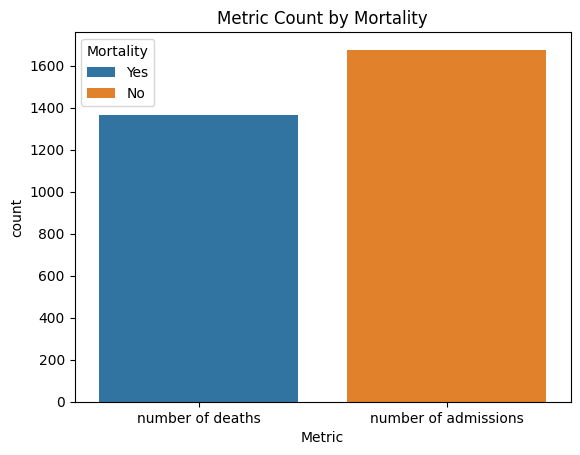

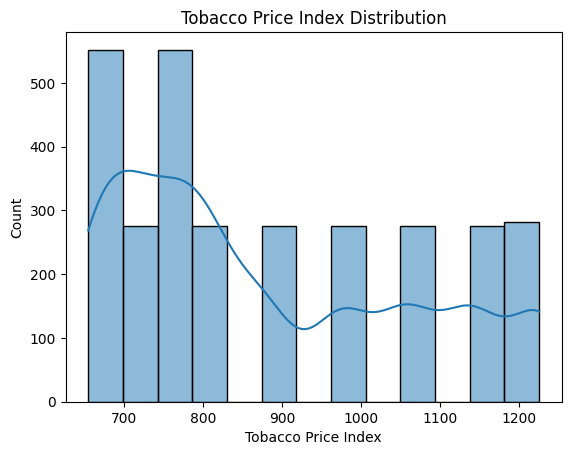

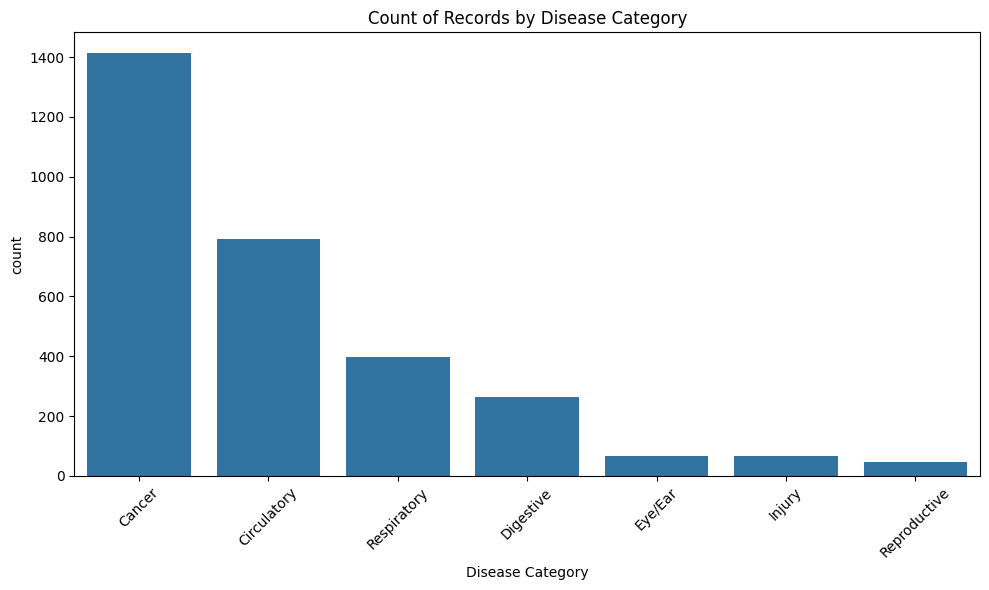

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Distribution of deaths vs admissions
sns.countplot(data=df, x='Metric', hue='Mortality')
plt.title("Metric Count by Mortality")
plt.show()

# 2. Tobacco price distribution
sns.histplot(df['Tobacco Price Index'], kde=True)
plt.title("Tobacco Price Index Distribution")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Disease Category', order=df['Disease Category'].value_counts().index)
plt.title('Count of Records by Disease Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


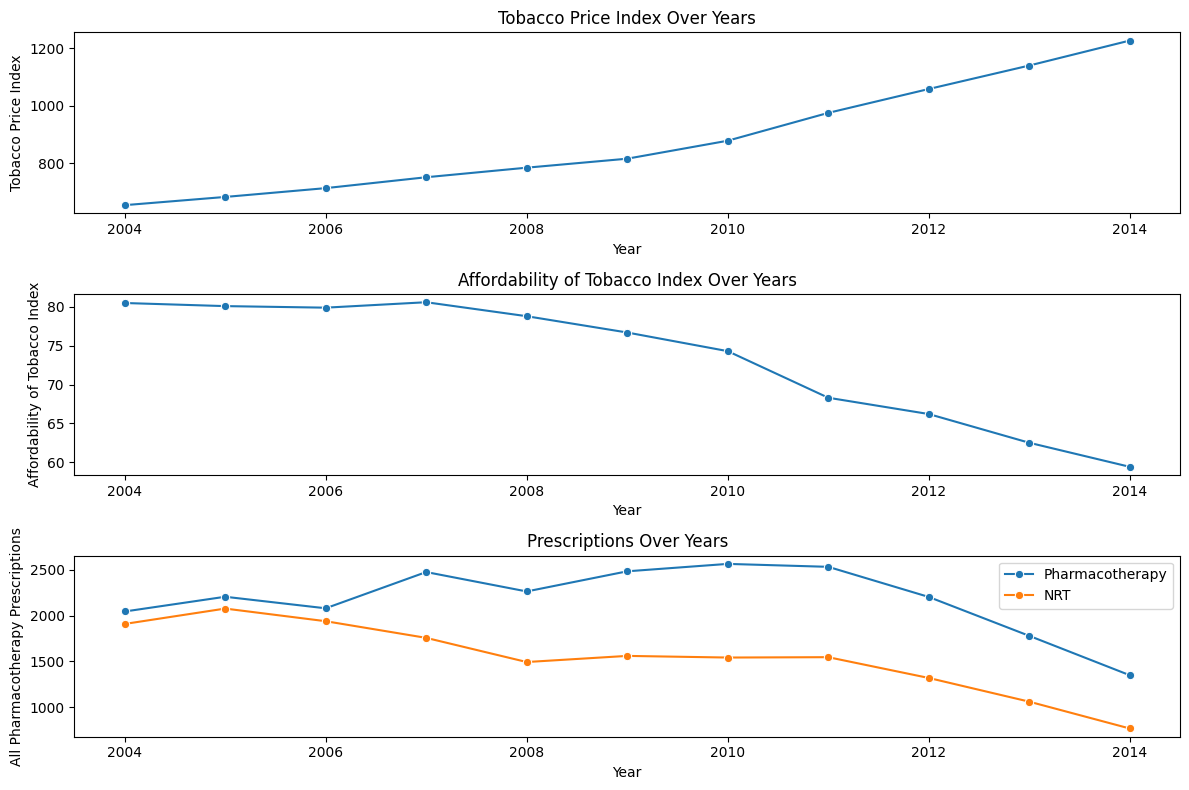

In [30]:
# Select unique year-level data (dropping duplicates on Year)
yearly_data = df.drop_duplicates(subset=['Year'])[['Year', 'Tobacco Price Index', 'Affordability of Tobacco Index', 
                                                  'All Pharmacotherapy Prescriptions', 'Nicotine Replacement Therapy (NRT) Prescriptions']]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
sns.lineplot(data=yearly_data, x='Year', y='Tobacco Price Index', marker='o')
plt.title('Tobacco Price Index Over Years')

plt.subplot(3, 1, 2)
sns.lineplot(data=yearly_data, x='Year', y='Affordability of Tobacco Index', marker='o')
plt.title('Affordability of Tobacco Index Over Years')

plt.subplot(3, 1, 3)
sns.lineplot(data=yearly_data, x='Year', y='All Pharmacotherapy Prescriptions', marker='o', label='Pharmacotherapy')
sns.lineplot(data=yearly_data, x='Year', y='Nicotine Replacement Therapy (NRT) Prescriptions', marker='o', label='NRT')
plt.title('Prescriptions Over Years')
plt.legend()

plt.tight_layout()
plt.show()


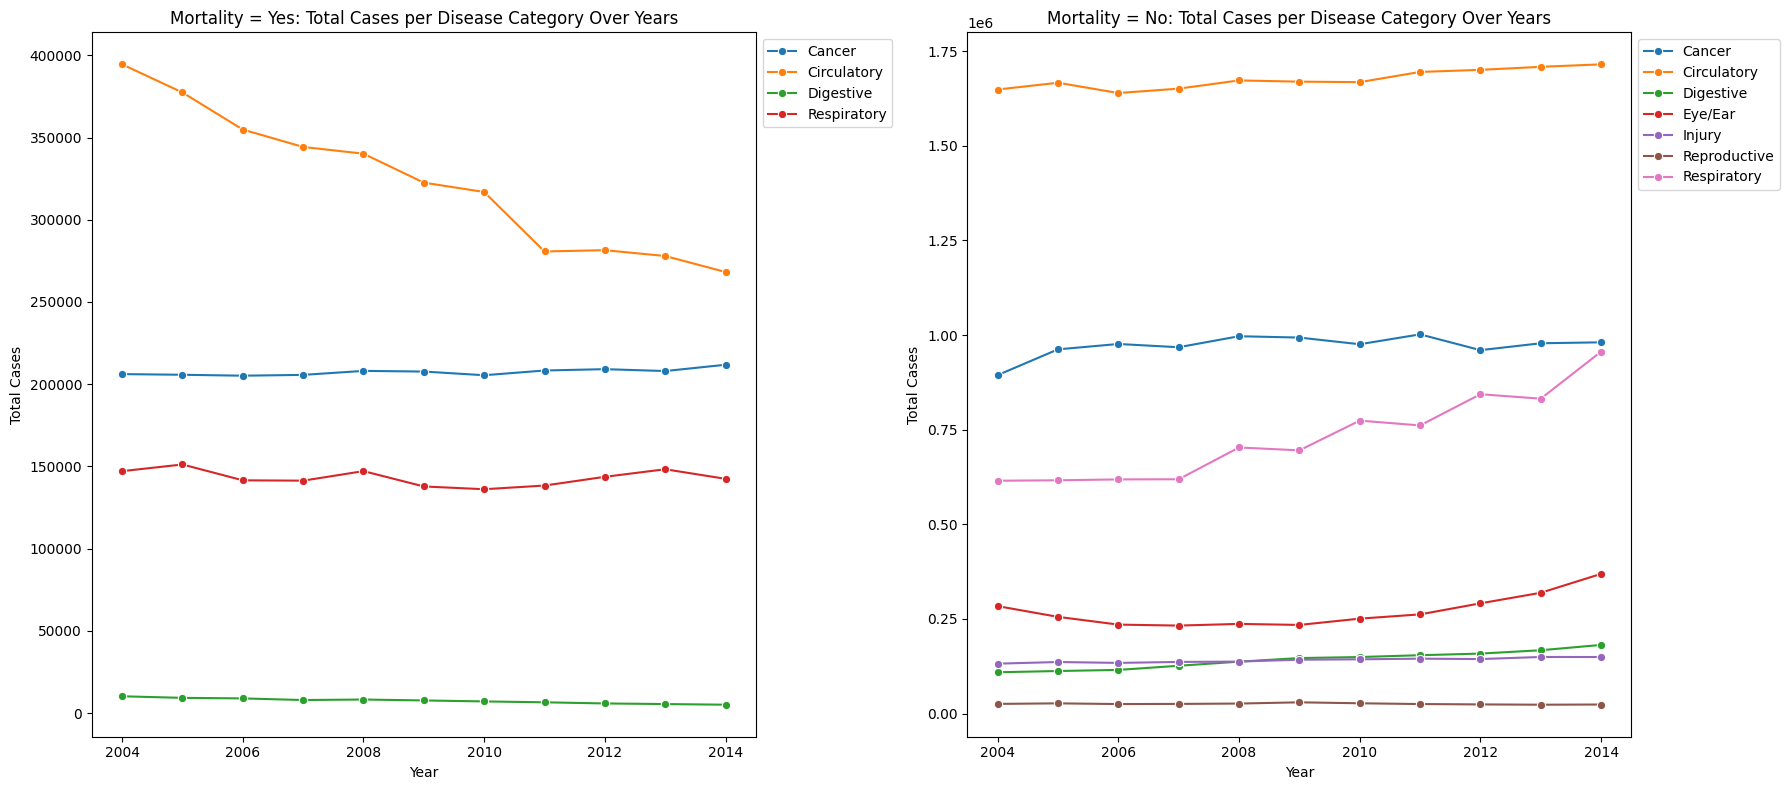

In [32]:
# Filter and group for Mortality = Yes
df_yes = df[df['Mortality'] == 'Yes']
grouped_yes = df_yes.groupby(['Year', 'Disease Category'])['Value'].sum().reset_index()

# Filter and group for Mortality = No
df_no = df[df['Mortality'] == 'No']
grouped_no = df_no.groupby(['Year', 'Disease Category'])['Value'].sum().reset_index()

# Plot setup
plt.figure(figsize=(18, 8))

# Plot Mortality = Yes
plt.subplot(1, 2, 1)
sns.lineplot(data=grouped_yes, x='Year', y='Value', hue='Disease Category', marker='o')
plt.title('Mortality = Yes: Total Cases per Disease Category Over Years')
plt.ylabel('Total Cases')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

# Plot Mortality = No
plt.subplot(1, 2, 2)
sns.lineplot(data=grouped_no, x='Year', y='Value', hue='Disease Category', marker='o')
plt.title('Mortality = No: Total Cases per Disease Category Over Years')
plt.ylabel('Total Cases')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()


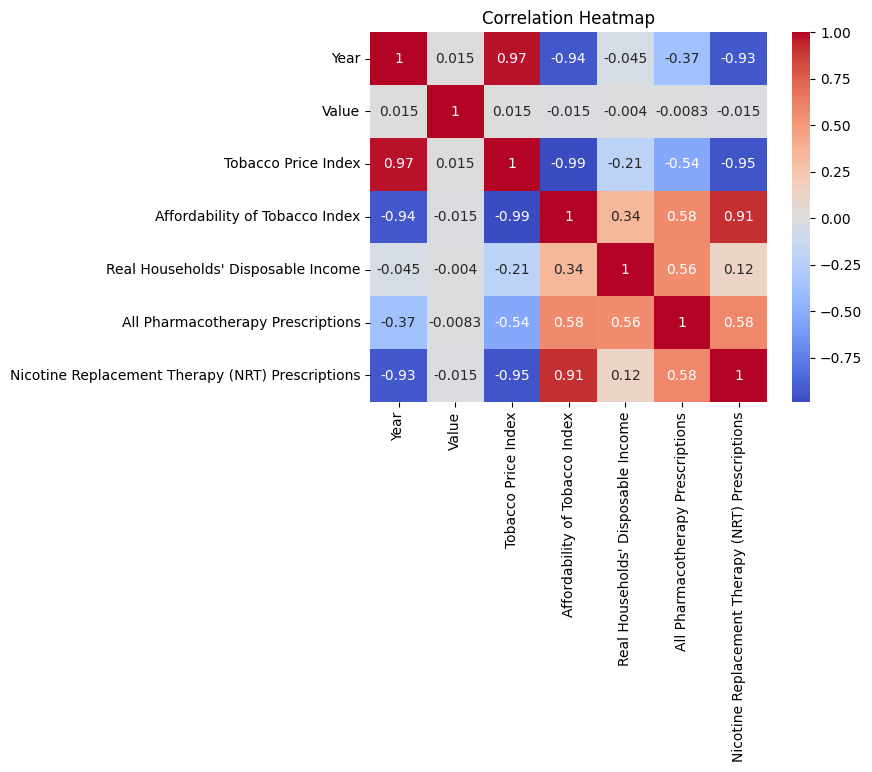

In [33]:
# Heatmap of numeric correlations
corr = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


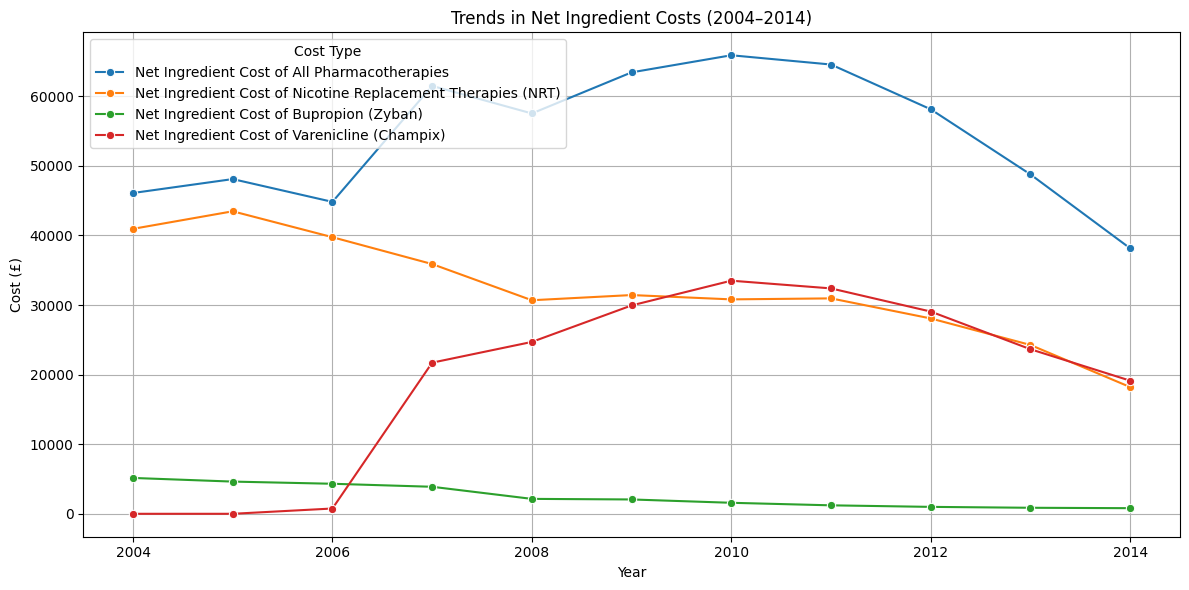

In [37]:
# Melt cost data
prescription_cost = prescriptions.melt(
    id_vars='Year',
    value_vars=[
        'Net Ingredient Cost of All Pharmacotherapies',
        'Net Ingredient Cost of Nicotine Replacement Therapies (NRT)',
        'Net Ingredient Cost of Bupropion (Zyban)',
        'Net Ingredient Cost of Varenicline (Champix)'
    ],
    var_name='Cost Type',
    value_name='Cost (£)'
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=prescription_cost, x='Year', y='Cost (£)', hue='Cost Type', marker='o')
plt.title("Trends in Net Ingredient Costs (2004–2014)")
plt.ylabel("Cost (£)")
plt.grid(True)
plt.tight_layout()
plt.show()


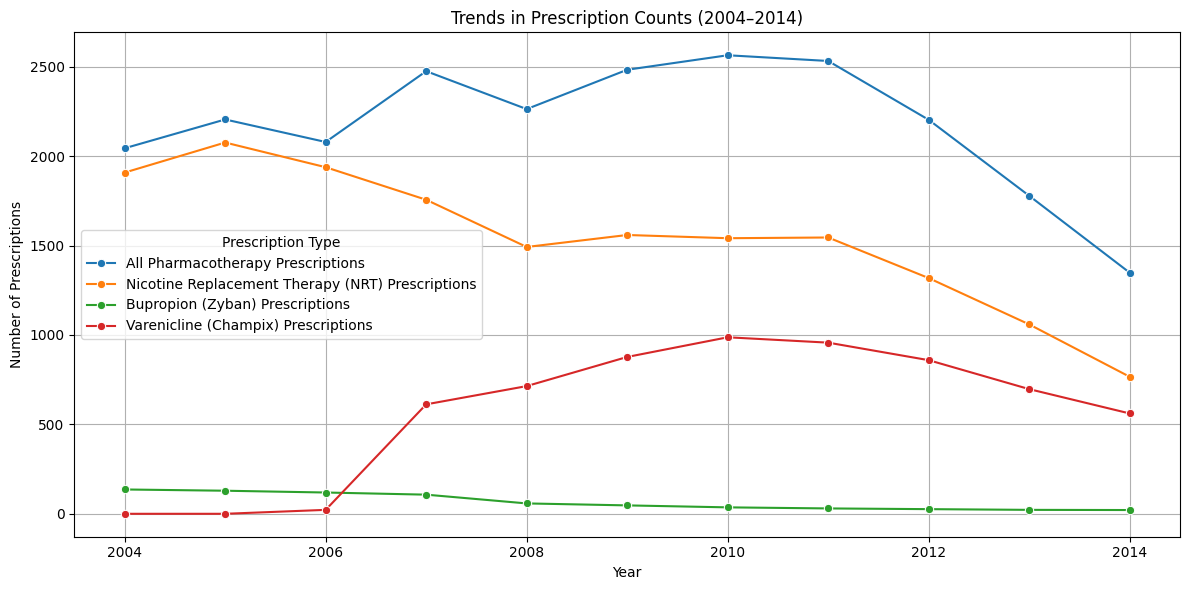

In [36]:
# Melt for plotting
prescription_count = prescriptions.melt(
    id_vars='Year',
    value_vars=[
        'All Pharmacotherapy Prescriptions',
        'Nicotine Replacement Therapy (NRT) Prescriptions',
        'Bupropion (Zyban) Prescriptions',
        'Varenicline (Champix) Prescriptions'
    ],
    var_name='Prescription Type',
    value_name='Count'
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=prescription_count, x='Year', y='Count', hue='Prescription Type', marker='o')
plt.title("Trends in Prescription Counts (2004–2014)")
plt.ylabel("Number of Prescriptions")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
'''Over the years (2004–2014), the Tobacco Affordability Index consistently declined, indicating that tobacco products became less affordable.

Simultaneously, the prescription of pharmacotherapies (e.g., NRT, Bupropion, Varenicline) increased, while their net ingredient costs either stabilized or decreased, suggesting improved accessibility and cost-effectiveness of treatment.

These trends align with a reduction in tobacco-related mortalities across several disease categories, especially cancers and circulatory diseases. The data implies that:

Tobacco became economically harder to sustain (pricing pressure).

Smoking cessation support became more available and affordable.

Public health interventions likely became more effective, contributing to reduced mortality.'''

In [41]:
# Drop unnecessary columns
df.drop(columns=['Metric', 'ICD10'], inplace=True)

In [42]:
from sklearn.preprocessing import LabelEncoder

# Encode Mortality: Yes = 1, No = 0
df['Mortality'] = df['Mortality'].map({'Yes': 1, 'No': 0})

# Custom label encoding for Disease Category
category_encoding = {
    'Cancer': 6,
    'Respiratory': 5,
    'Circulatory': 4,
    'Digestive': 3,
    'Eye/Ear': 2,
    'Reproductive': 1,
    'Injury': 0
}

df['Disease Category'] = df['Disease Category'].map(category_encoding)


In [43]:
df

,Year,Value,Mortality,Tobacco Price Index,Affordability of Tobacco Index,Real Households' Disposable Income,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,Disease Category
0,2011,22900.0,1,974.9,68.3,189.3,2532,1545,6
1,2012,16200.0,0,1057.8,66.2,192.9,2203,1318,4
2,2014,780.0,1,1226.0,59.4,190.0,1348,766,3
3,2011,5800.0,0,974.9,68.3,189.3,2532,1545,4
4,2007,100.0,1,751.5,80.6,195.9,2475,1756,4
...,...,...,...,...,...,...,...,...,...
3037,2004,500.0,1,654.6,80.5,188.7,2044,1908,5
3038,2007,4528.0,0,751.5,80.6,195.9,2475,1756,6
3039,2007,79000.0,0,751.5,80.6,195.9,2475,1756,5
3040,2006,11400.0,0,713.7,79.9,192.3,2079,1938,3


In [44]:
# Total rows
total_rows = df.shape[0]

# Count of mortality = 1
count_mortality_1 = df['Mortality'].sum()

# Count of mortality = 0
count_mortality_0 = (df['Mortality'] == 0).sum()

print(f"Total rows: {total_rows}")
print(f"Mortality = 1 count: {count_mortality_1}")
print(f"Mortality = 0 count: {count_mortality_0}")


Total rows: 3042
Mortality = 1 count: 1366
Mortality = 0 count: 1676


In [45]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('Mortality', axis=1)
y = df['Mortality']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Scale features for SGD and Logistic Regression
scaler = StandardScaler()

# Fit scaler on training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform test data
X_test_scaled = scaler.transform(X_test)

# Step 2: Initialize models with L2 regularization (default penalty='l2')
sgd = SGDClassifier(loss='log_loss', penalty='l2', random_state=42, max_iter=1000, tol=1e-3)
log_reg = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)

# Step 3: Train models
sgd.fit(X_train_scaled, y_train)
log_reg.fit(X_train_scaled, y_train)

# Step 4: Predictions
y_pred_sgd = sgd.predict(X_test_scaled)
y_pred_log = log_reg.predict(X_test_scaled)

# Step 5: Evaluate
print("SGD Classifier Performance:")
print(classification_report(y_test, y_pred_sgd))

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))


SGD Classifier Performance:
              precision    recall  f1-score   support

           0       0.78      0.57      0.66       336
           1       0.60      0.80      0.69       273

    accuracy                           0.67       609
   macro avg       0.69      0.68      0.67       609
weighted avg       0.70      0.67      0.67       609

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.72      0.67      0.70       336
           1       0.63      0.68      0.65       273

    accuracy                           0.68       609
   macro avg       0.68      0.68      0.68       609
weighted avg       0.68      0.68      0.68       609



In [47]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize models
rf = RandomForestClassifier(random_state=42, n_estimators=100)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train on unscaled data
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print("Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rf))

print("XGBoost Classifier Performance:")
print(classification_report(y_test, y_pred_xgb))


Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.71      0.66      0.69       336
           1       0.62      0.67      0.64       273

    accuracy                           0.67       609
   macro avg       0.67      0.67      0.67       609
weighted avg       0.67      0.67      0.67       609

XGBoost Classifier Performance:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       336
           1       0.72      0.73      0.72       273

    accuracy                           0.75       609
   macro avg       0.75      0.75      0.75       609
weighted avg       0.75      0.75      0.75       609



In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Logistic Regression Grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # l1 needs solver='liblinear' which can be tried separately
    'solver': ['lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train_scaled, y_train)

print("Best LR params:", grid_lr.best_params_)
print("Best LR F1 score:", grid_lr.best_score_)


# XGBoost Grid
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'gamma': [0, 1, 5]
}

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_xgb = GridSearchCV(xgb_clf, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB F1 score:", grid_xgb.best_score_)


Best LR params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best LR F1 score: 0.6666936388490485
Best XGB params: {'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.7}
Best XGB F1 score: 0.7303853525205463


In [50]:
# finalizing the model
best_params = {
    'colsample_bytree': 1,
    'gamma': 1,
    'learning_rate': 0.01,
    'max_depth': 7,
    'n_estimators': 150,
    'subsample': 0.7,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

from xgboost import XGBClassifier

xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train, y_train)

y_pred = xgb_best.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7947454844006568

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82       336
           1       0.79      0.73      0.76       273

    accuracy                           0.79       609
   macro avg       0.79      0.79      0.79       609
weighted avg       0.79      0.79      0.79       609


Confusion Matrix:
 [[284  52]
 [ 73 200]]


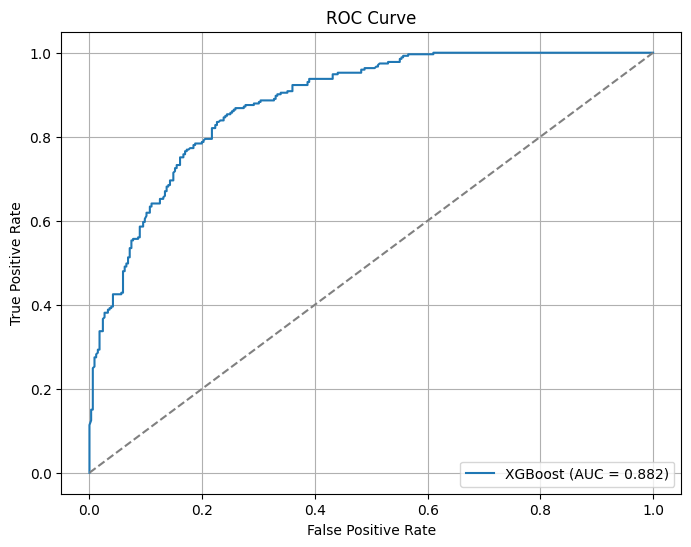

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the positive class
y_probs = xgb_best.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


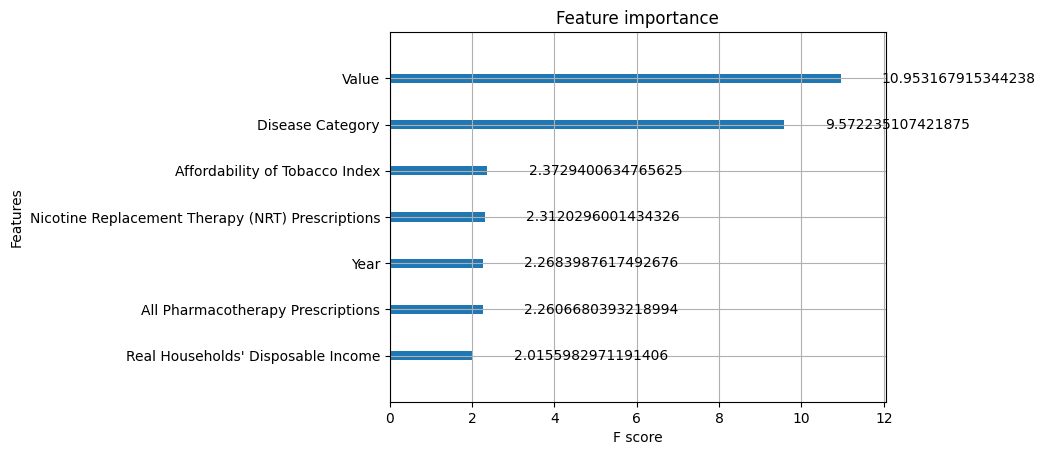

In [53]:
# feature importance
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_best, importance_type='gain')
plt.show()

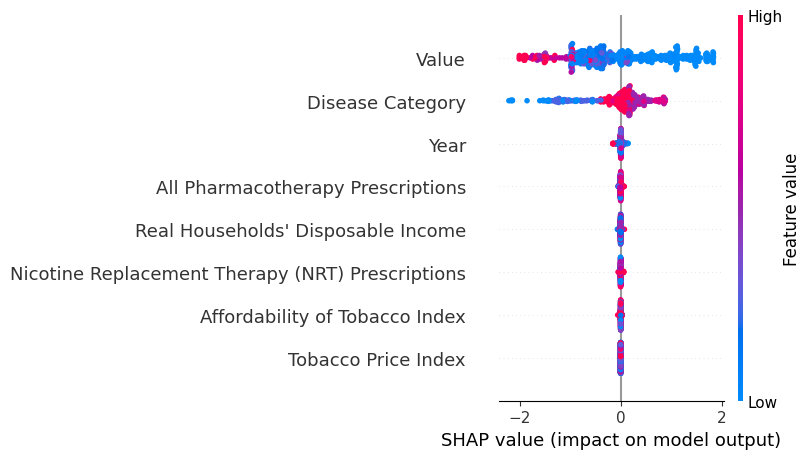

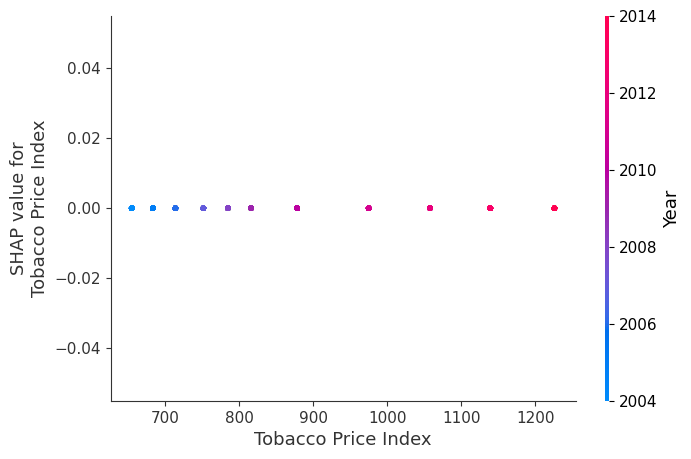

In [55]:
#SHAP explaination
import shap

# Create object that explains the model's predictions
explainer = shap.TreeExplainer(xgb_best)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance and impact)
shap.summary_plot(shap_values, X_test)

# Dependence plot for one important feature
shap.dependence_plot("Tobacco Price Index", shap_values, X_test)

In [ ]:
🔍 Final Verdict & Limitations
Aggregated Data Limitation: The dataset used consists of aggregated annual statistics (e.g., deaths or admissions per year), which do not reflect individual-level variation. This violates the core assumption of machine learning models that each row is an independent observation.

Static Feature Values: Features like tobacco price index, affordability index, and pharmacotherapy prescriptions remain constant across rows for the same year. This leads to a lack of feature variability, reducing the model’s ability to distinguish between cases effectively.

Outcome Leakage Risk: The 'Value' column, which includes number of deaths or admissions, is a result of the underlying factors and also strongly correlated with the target (Mortality). Including it can lead to data leakage, while excluding it weakens the model’s predictive power.

Causal Direction & Policy Modeling: Variables such as price, affordability, and treatment are macro-level indicators. Mortality trends influenced by these are observable at a population level, not meant for individual prediction. Thus, this data is better suited for trend analysis and policy insights, not for reliable classification.

Proper Usage Recommendation: This model should be treated as an exploratory policy tool to understand associations (e.g., “decreasing affordability reduces tobacco use and mortality”), not as a predictive healthcare model.